In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (
    train_test_split, GridSearchCV, 
)
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    accuracy_score, confusion_matrix, ConfusionMatrixDisplay
)

#Fill NaN series with random values based on distribution excluding greater/less than n_std away from mean
def fill_na_with_random_continuous(series, n_std=3):
    
    #Create a copy
    series = series.copy()
    
    # Drop NaN values
    values = series.dropna()
    
    # Calculate mean and standard deviation
    mean, std = values.mean(), values.std()
    
    # Filter values to within n standard deviations
    filtered_values = values[(values >= mean - n_std * std) & (values <= mean + n_std * std)]
    
    # Compute the CDF
    values_sorted = np.sort(filtered_values)
    cdf = np.arange(1., len(filtered_values) + 1) / len(filtered_values)
    
    # Generate random values
    random_values = np.random.rand(series.isna().sum())
    
    # Get random choices from the CDF
    random_choices = np.interp(random_values, cdf, values_sorted)
    
    # Fill NaN values
    series.loc[series.isna()] = random_choices
    
    return series

#Fill NaN series with random values based on count distribution excluding counts with less than n_std away from mean counts
def fill_na_with_random_categorical(series):
    
    #Create a copy
    series = series.copy()
    
    # Drop NaN values
    values = series.dropna()
    
    # Calculate counts and the mean/std of the counts
    counts = values.value_counts()
    
    # Compute probabilities
    probabilities = (counts / counts.sum()).to_dict()
    
    #Generate random values according to the distribution
    random_values = np.random.choice(list(probabilities.keys()), size=series.isna().sum(), p=list(probabilities.values()))
    
    #Fill NaN values
    series.loc[series.isna()] = random_values
    
    return series

#Fill na series with mean,mode or median
def fill_na(series, fill_type:str):
    
    # Create a copy
    series = series.copy()
    
    # Input validation
    if fill_type not in ['mean', 'mode', 'median']:
        raise ValueError("fill_type must be one of 'mean', 'mode', or 'median'")
    
    if fill_type == 'mean':
        return series.fillna(series.mean())
    elif fill_type == 'mode':
        # mode() returns a Series, so take first mode value
        return series.fillna(series.mode()[0])
    elif fill_type == 'median':
        return series.fillna(series.median())

#For a df drop NA if ratio of non NA to NA is less than specified  
def df_drop_na(df, ratio = 0.5):
    for column in df.columns:
        
        # Calculate the ratio of non-NaN values to total values
        non_nan_ratio = df[column].count() / len(df[column])
        
        # If the ratio is less than the threshold, drop the column
        if non_nan_ratio < ratio:
            df.drop(column, axis=1, inplace=True)

#Generate random value from pandas column
def random_value(column, discrete:bool):
    if discrete == True:
        probs = column.value_counts(normalize=True)
        return np.random.choice(probs.index, p=probs.values)
    else:
        return column.sample(weights=column.value_counts(normalize=True)).iloc[0]
    
#Import Mushroom tabular datasets
df1 = pd.read_csv("Dataset1/secondary_data.csv", sep=";")

#Remove duplicates
df1 = df1.drop_duplicates()

In [2]:
df1.columns

Index(['class', 'cap-diameter', 'cap-shape', 'cap-surface', 'cap-color',
       'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color',
       'stem-height', 'stem-width', 'stem-root', 'stem-surface', 'stem-color',
       'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color',
       'habitat', 'season'],
      dtype='object')

In [3]:
df1.isnull().sum(axis = 0)

class                       0
cap-diameter                0
cap-shape                   0
cap-surface             14120
cap-color                   0
does-bruise-or-bleed        0
gill-attachment          9855
gill-spacing            25062
gill-color                  0
stem-height                 0
stem-width                  0
stem-root               51536
stem-surface            38122
stem-color                  0
veil-type               57746
veil-color              53510
has-ring                    0
ring-type                2471
spore-print-color       54597
habitat                     0
season                      0
dtype: int64

### Histograms before cleaning

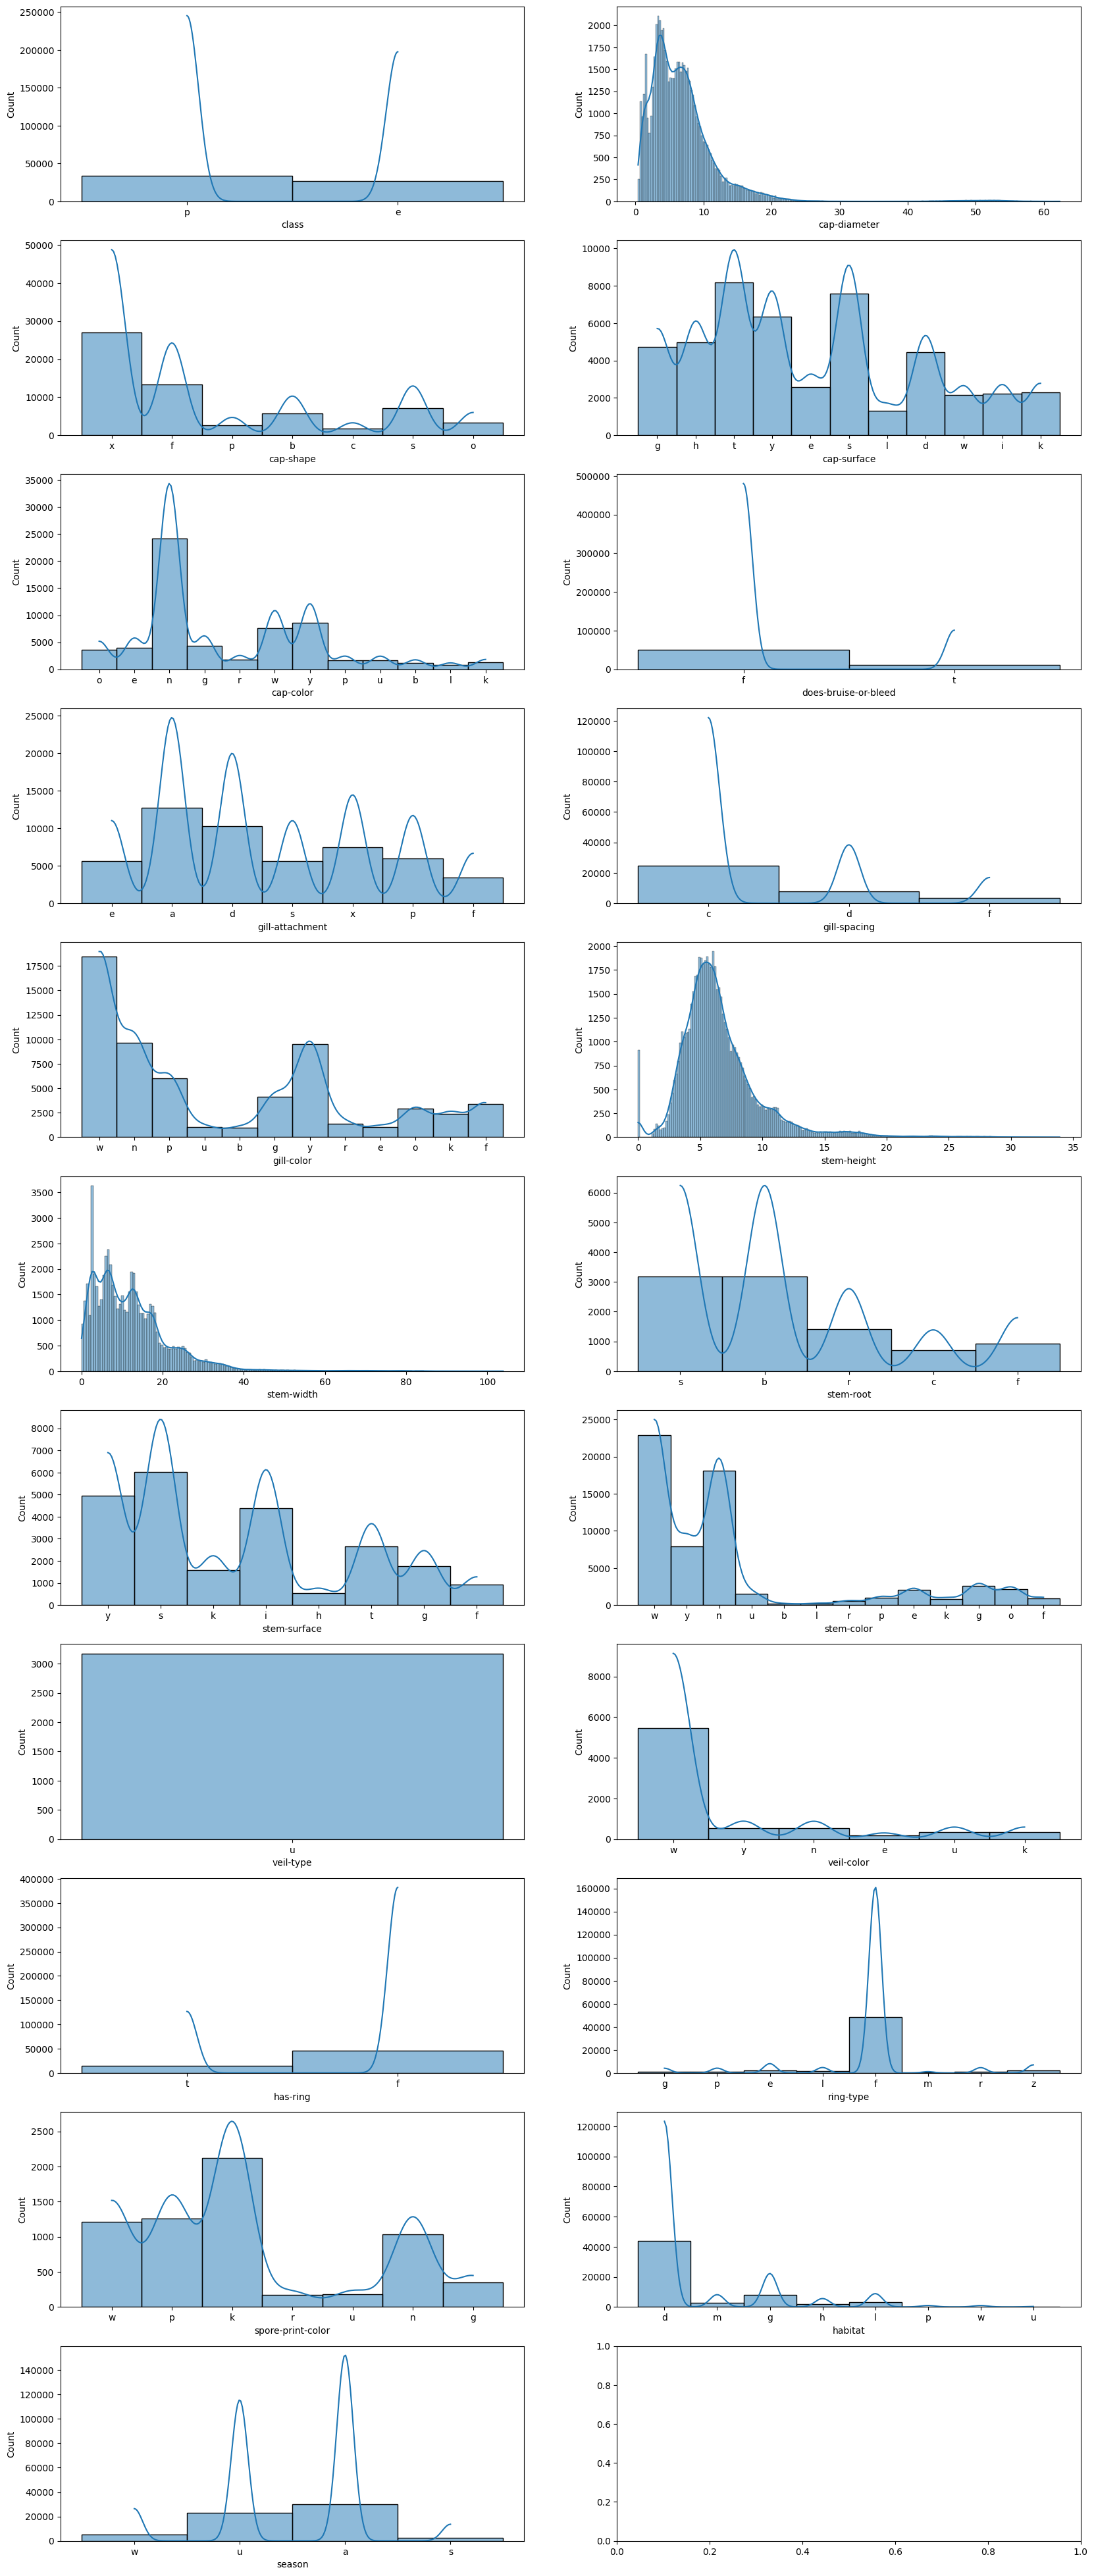

In [4]:
fig, axs = plt.subplots(11, 2, figsize=(20, 50))
axs = axs.ravel()

for i, column_name in enumerate(df1):
    sns.histplot(data=df1[column_name], kde=True, ax = axs[i])

### Cleaning

In [5]:
df_clean = df1

#Remove columns with more than 50% NaN values
df_drop_na(df_clean, 0.5)
    
#Fill in remaining NaN with random values from distribution
df_clean["cap-surface"] = fill_na_with_random_categorical(df1["cap-surface"])
df_clean["gill-attachment"] = fill_na_with_random_categorical(df1["gill-attachment"])
df_clean["gill-spacing"] = fill_na_with_random_categorical(df1["gill-spacing"])
df_clean["ring-type"] = fill_na_with_random_categorical(df1["ring-type"])

#Rename columns
df_clean.rename(columns={'cap-diameter':'cap_diameter', 'cap-shape':'cap_shape', 'cap-surface':'cap_surface', 'cap-color':'cap_color', 'does-bruise-or-bleed':'bruise/bleed', 
                         'gill-attachment':'gill_attachment', 'gill-spacing':'gill_spacing', 'gill-color':'gill_color', 'stem-height':'stem_height', 'stem-width':'stem_width', 
                         'stem-color':'stem_color', 'has-ring':'has_ring',
                         'ring-type' : 'ring_type', 'spore-print-color' : 'spore_print_color'}, inplace=True)
#Rename catagories
df_clean['cap_shape'] = df_clean['cap_shape'].map({'b':'bell', 'c':'conical', 'x':'convex', 'f':'flat', 's':'sunken', 'p':'spherical', 'o':'others'})
df_clean['cap_surface'] = df_clean['cap_surface'].map({'i':'fibrous', 'g':'grooves', 'y':'scaly', 's':'smooth', 'h':'shiny', 'l':'leathery', 'k':'silky', 't':'sticky', 'w':'wrinkled', 'e':'fleshy', 'd':'unknown'})
df_clean['cap_color'] = df_clean['cap_color'].map({'n':'brown', 'b':'buff', 'g':'grey', 'r':'green', 'p':'pink', 'u':'purple', 'e':'red', 'w':'white', 'y':'yellow', 'l':'blue', 'o':'orange', 'k':'black'})
df_clean['gill_color'] = df_clean['gill_color'].map({'n':'brown', 'b':'buff', 'g':'grey', 'r':'green', 'p':'pink', 'u':'purple', 'e':'red', 'w':'white', 'y':'yellow', 'l':'blue', 'o':'orange', 'k':'black', 'f':'none'})
df_clean['gill_attachment'] = df_clean['gill_attachment'].map({'a':'adnate', 'x':'adnexed', 'd':'decurrent', 'e':'free', 's':'sinuate', 'p':'pores', 'f':'none'})
df_clean['gill_spacing'] = df_clean['gill_spacing'].map({'c':'close', 'd':'distant', 'f':'none'})
df_clean['stem_color'] = df_clean['stem_color'].map({'n':'brown', 'b':'buff', 'g':'grey', 'r':'green', 'p':'pink', 'u':'purple', 'e':'red', 'w':'white', 'y':'yellow', 'l':'blue', 'o':'orange', 'k':'black', 'f':'none'})
df_clean['ring_type'] = df_clean['ring_type'].map({'c':'cobwebby', 'e':'evanescent', 'r':'flaring', 'g':'grooved', 'l':'large', 'p':'pendant', 's':'sheathing', 'z':'zone', 'y':'yellow', 'y':'scaly', 'm':'movable', 'f':'none'})
df_clean['habitat'] = df_clean['habitat'].map({'g':'grasses', 'l':'leaves', 'm':'meadows', 'p':'paths', 'h':'heaths', 'u':'urban', 'w':'waste', 'd':'woods'})
df_clean['season'] = df_clean['season'].map({'s':'spring', 'u':'summer', 'a':'autumn', 'w':'winter'})

#Convert poisionous(p, e) to is_posionious(true, false)
df_clean["is_poisonous"] = np.where(df_clean['class'] == 'p', True, False)
df_clean.drop(columns="class", inplace = True)

### Continious Variable pairplot

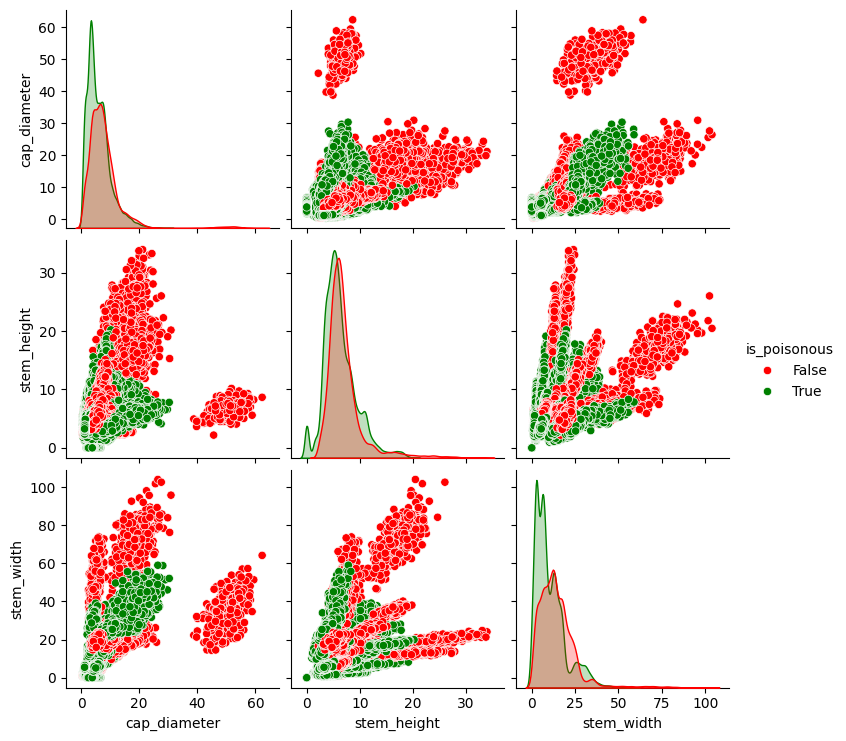

In [6]:
sns.pairplot(df_clean[["is_poisonous", "cap_diameter", "stem_height", "stem_width"]], hue="is_poisonous", palette=["red", "green"])

In [7]:
df_clean.columns

Index(['cap_diameter', 'cap_shape', 'cap_surface', 'cap_color', 'bruise/bleed',
       'gill_attachment', 'gill_spacing', 'gill_color', 'stem_height',
       'stem_width', 'stem_color', 'has_ring', 'ring_type', 'habitat',
       'season', 'is_poisonous'],
      dtype='object')

In [8]:
df1.isnull().sum(axis = 0)

cap_diameter       0
cap_shape          0
cap_surface        0
cap_color          0
bruise/bleed       0
gill_attachment    0
gill_spacing       0
gill_color         0
stem_height        0
stem_width         0
stem_color         0
has_ring           0
ring_type          0
habitat            0
season             0
is_poisonous       0
dtype: int64

### Histogram after clean

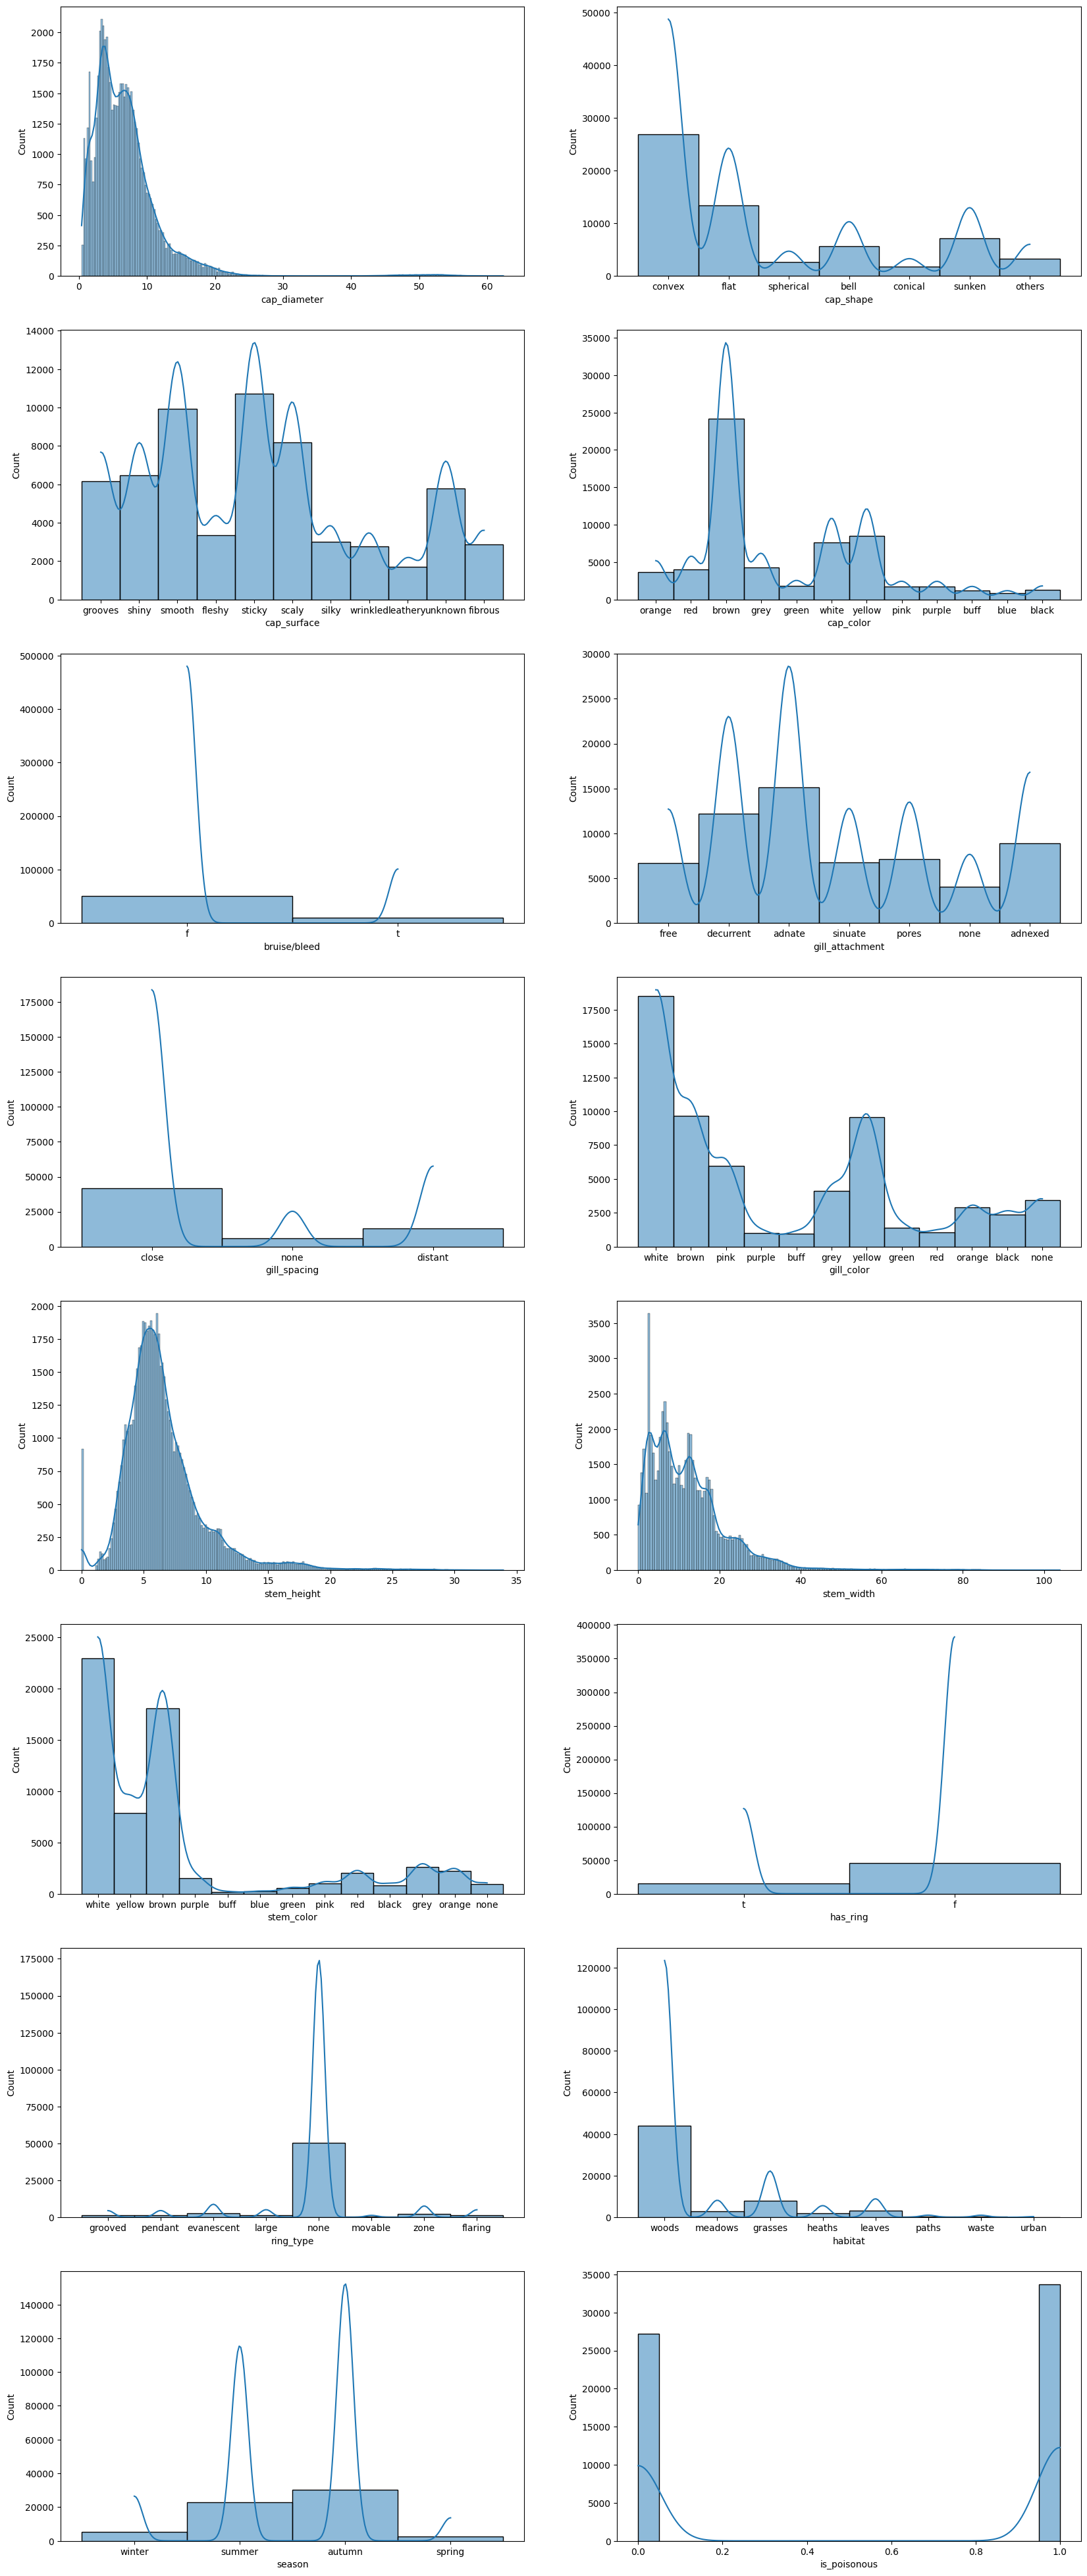

In [9]:
fig, axs = plt.subplots(8, 2, figsize=(20, 50))
axs = axs.ravel()

for i, column_name in enumerate(df_clean):
    sns.histplot(data=df_clean[column_name], kde=True, ax = axs[i])

### Correlation

In [10]:
#One hot encoding for gill colour and cap color
df_clean_One_Hot = pd.get_dummies(data = df_clean, columns = ["gill_color"], drop_first=True)
df_clean_One_Hot = pd.get_dummies(data = df_clean_One_Hot, columns = ["cap_color"], drop_first=True)

Text(0.5, 1.0, 'Correlation Heatmap')

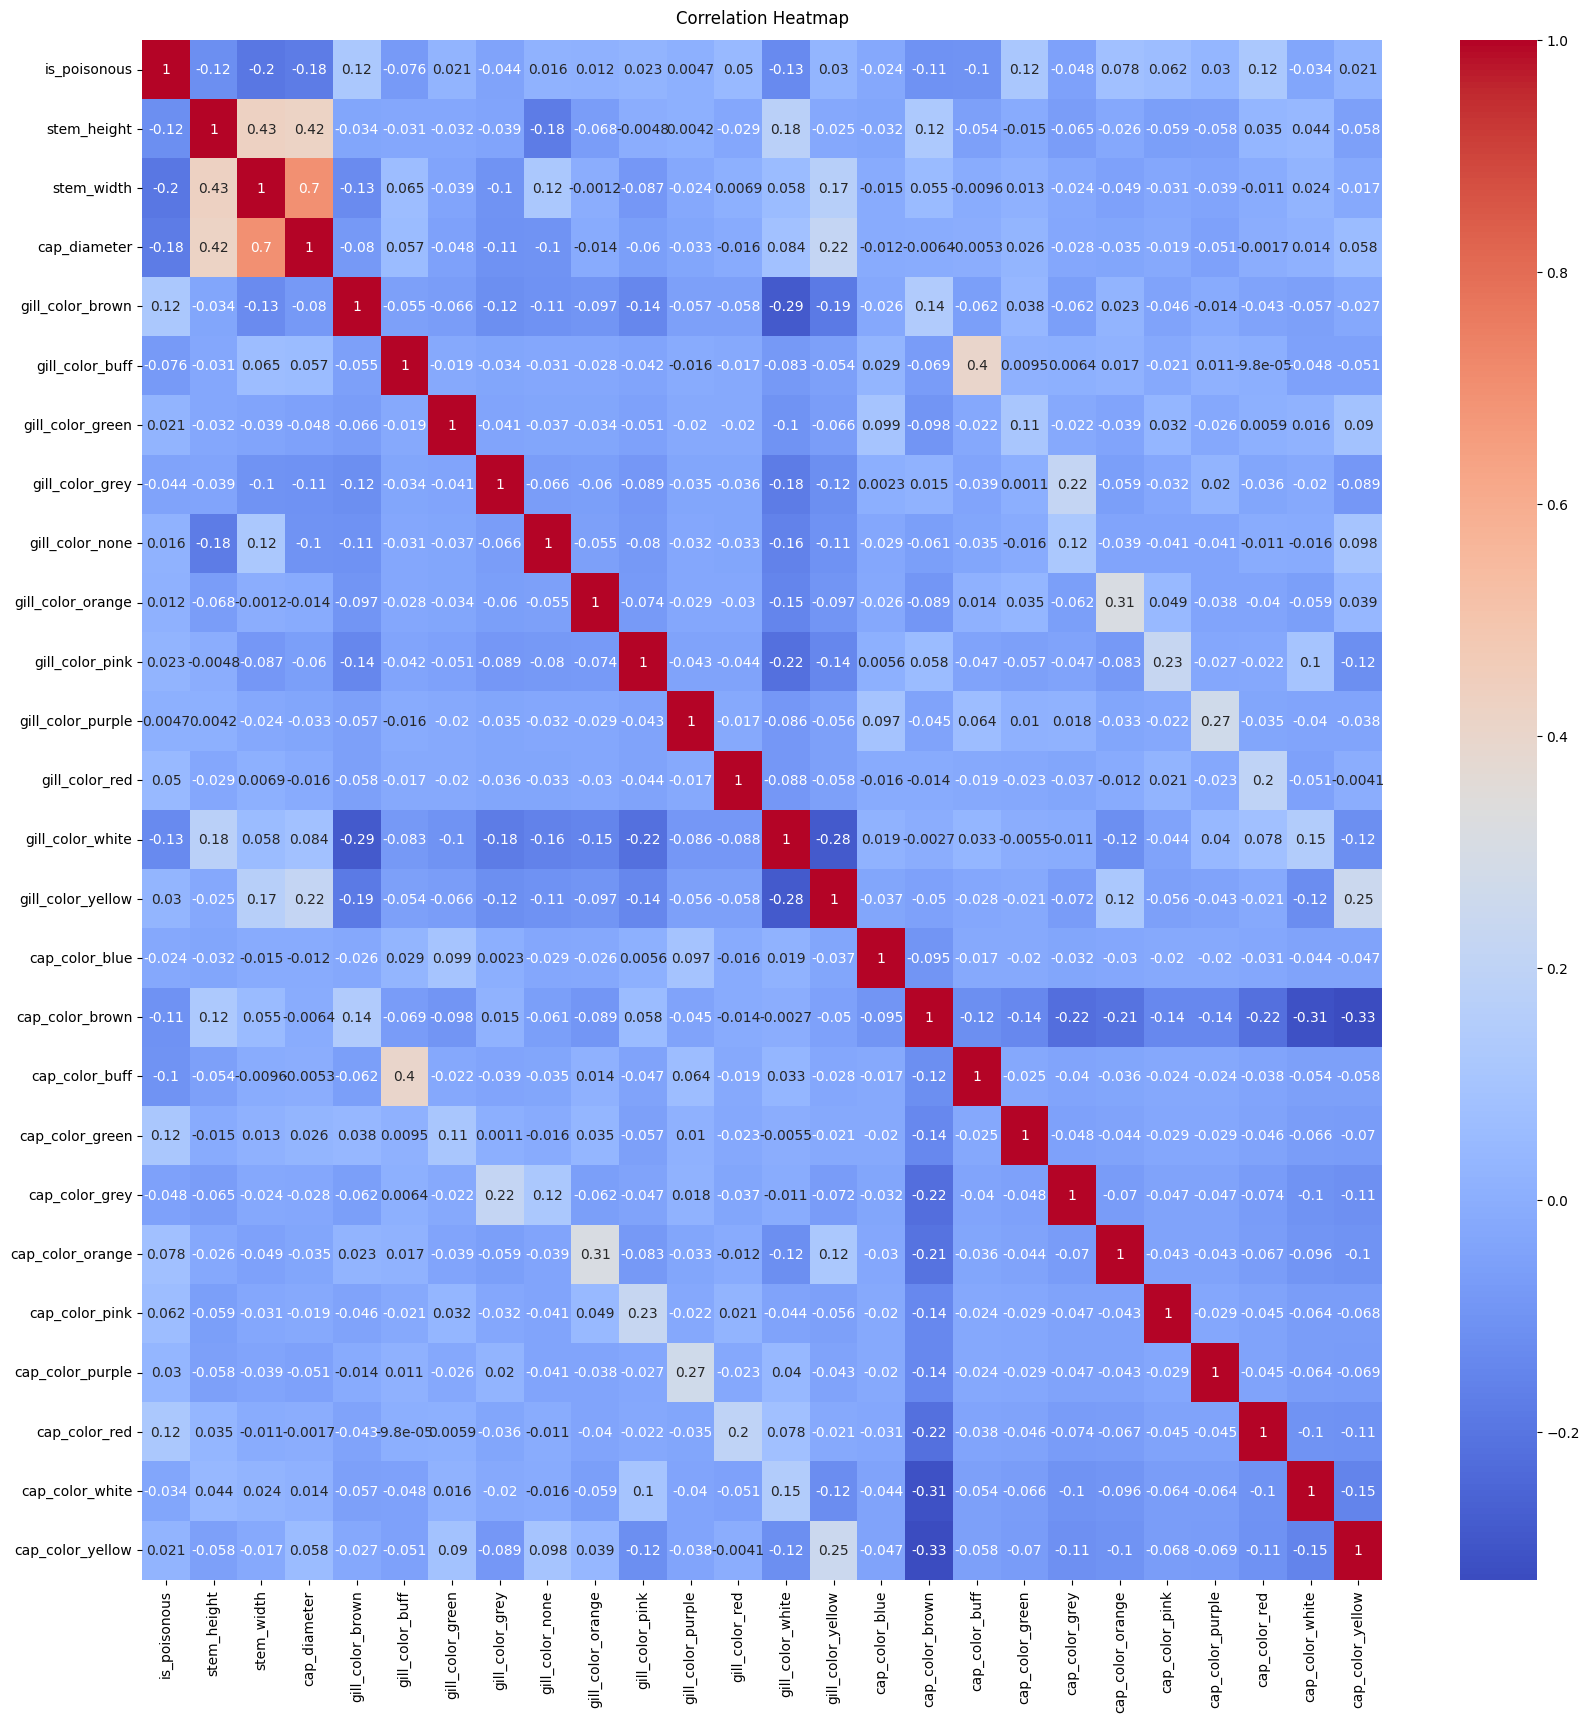

In [11]:
df_corr = df_clean_One_Hot[["is_poisonous", "stem_height", "stem_width", "cap_diameter", "gill_color_brown", "gill_color_buff", "gill_color_green", "gill_color_grey", 
                            "gill_color_none", "gill_color_orange", "gill_color_pink","gill_color_purple", "gill_color_red", "gill_color_white", "gill_color_yellow", 
                            "cap_color_blue", "cap_color_brown", "cap_color_buff", "cap_color_green", "cap_color_grey", "cap_color_orange", "cap_color_pink", "cap_color_purple",
                            "cap_color_red", "cap_color_white", 'cap_color_yellow']]
plt.figure(figsize = (20, 20))
sns.heatmap(df_corr.corr(), annot=True, cmap="coolwarm", annot_kws={"size": 10}).set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

### Encoding and train_test_split

In [12]:
encoder = OrdinalEncoder(handle_missing='error')
Encoded = encoder.fit_transform(df_clean)
print(Encoded.head())

y = Encoded["is_poisonous"]
X = Encoded.drop(columns = "is_poisonous")

for m in encoder.get_params()['mapping']:
    print(f"{m['col']}:\n{m['mapping'].to_string()}\n")
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

   cap_diameter  cap_shape  cap_surface  cap_color  bruise/bleed  \
0         15.26          1            1          1             1   
1         16.60          1            1          1             1   
2         14.07          1            1          1             1   
3         14.17          2            2          2             1   
4         14.64          1            2          1             1   

   gill_attachment  gill_spacing  gill_color  stem_height  stem_width  \
0                1             1           1        16.95       17.09   
1                1             2           1        17.99       18.19   
2                1             2           1        17.80       17.74   
3                1             2           1        15.77       15.98   
4                1             1           1        16.53       17.20   

   stem_color  has_ring  ring_type  habitat  season  is_poisonous  
0           1         1          1        1       1          True  
1           1   

### Random Forest

In [13]:
#Create number of models with different parameters then fit data to them
model = GridSearchCV(
    RandomForestClassifier(random_state=42),
    {
        "n_estimators": [200, 250, 300, 350],
        "max_depth": [20, 25, 30, 35, 40],
        "criterion": ["gini", "entropy"]
    },
    n_jobs=-1, scoring="precision", cv=5
)

model.fit(X_train, y_train)

#Best GridSearchCV params
print("Best GridSearchCV Parameters:", model.best_params_)

#Feature importance
feature_importances = model.best_estimator_.feature_importances_
feature_names = X.columns
feature_importances = pd.DataFrame(feature_importances, index=feature_names, columns=["importance"]).sort_values("importance", ascending=False)
print(feature_importances)

Best GridSearchCV Parameters: {'criterion': 'gini', 'max_depth': 20, 'n_estimators': 200}
                 importance
stem_width         0.144742
stem_height        0.095977
gill_color         0.093226
gill_attachment    0.090127
stem_color         0.089306
cap_diameter       0.089189
cap_surface        0.075748
cap_color          0.063081
cap_shape          0.062580
bruise/bleed       0.041213
gill_spacing       0.038452
ring_type          0.037597
has_ring           0.032340
habitat            0.030683
season             0.015739


 precision_score: 0.999183
    recall_score: 1.000000
        f1_score: 0.999592
  accuracy_score: 0.999549


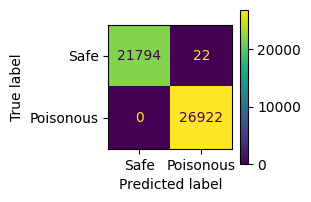

In [14]:
#Train predictions (>0.2 to be classified as Poisonous)
y_pred = model.best_estimator_.predict_proba(X_train)[:,1] >= 0.2

for f in (precision_score, recall_score, f1_score, accuracy_score):
        print(f"{f.__name__:>16s}: {f(y_train, y_pred):.6f}")
        
cm = confusion_matrix(y_train, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=['Safe', 'Poisonous'])
fig, ax = plt.subplots(figsize=(2, 2))
cmd.plot(ax=ax)

 precision_score: 0.989840
    recall_score: 1.000000
        f1_score: 0.994894
  accuracy_score: 0.994255


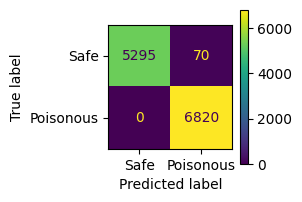

In [15]:
#Test predictions (>0.2 to be classified as Poisonous)
y_pred = model.best_estimator_.predict_proba(X_test)[:,1] >= 0.2

for f in (precision_score, recall_score, f1_score, accuracy_score):
        print(f"{f.__name__:>16s}: {f(y_test, y_pred):.6f}")
        
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=['Safe', 'Poisonous'])
fig, ax = plt.subplots(figsize=(2, 2))
cmd.plot(ax=ax)